In [1]:
! pip install -q transformers scikit-learn matplotlib tqdm

In [2]:
! pip install -q torch torchvision torchaudio torchcodec --index-url https://download.pytorch.org/whl/cu126

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.8 MB/s eta 0:00:0000:0100:01


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.8.0+cu126
True
Tesla T4


In [5]:
import os
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio")

import torch
import torchaudio
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from transformers import WhisperModel
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    brier_score_loss,
    precision_score
)
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
AUDIO_DIR = "/kaggle/input/hs-dataset/Heart_sound_dataset/HS_wav_dataset"
META_JSON = "/kaggle/input/hs-dataset/Heart_sound_dataset/meta_map.json"

SAMPLE_RATE = 2000
MAX_SEC = 30
MAX_LEN = SAMPLE_RATE * MAX_SEC
BATCH_SIZE = 8

In [7]:
class MurmurDataset(Dataset):
    def __init__(self, audio_dir, meta_json,
                 sr=SAMPLE_RATE, max_len=MAX_LEN):
        with open(meta_json, "r") as f:
            self.meta = json.load(f)

        self.audio_dir = audio_dir
        self.files = list(self.meta.keys())
        self.sr = sr
        self.max_len = max_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.meta[fname]

        wav, sr = torchaudio.load(
            os.path.join(self.audio_dir, fname)
        )
        wav = wav.mean(0)

        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        wav = wav / (wav.abs().max() + 1e-6)

        if wav.shape[0] < self.max_len:
            wav = torch.nn.functional.pad(
                wav, (0, self.max_len - wav.shape[0])
            )

        wav = wav[:self.max_len]
        return wav, torch.tensor(label, dtype=torch.long)

In [8]:
dataset = MurmurDataset(AUDIO_DIR, META_JSON,sr=SAMPLE_RATE, max_len=MAX_LEN)

labels = [dataset.meta[f] for f in dataset.files]

train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.1,
    random_state=42,
    stratify=labels
)

train_ds = Subset(dataset, train_idx)
train_labels = [dataset.meta[dataset.files[i]] for i in train_idx]

class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts

sample_weights = [class_weights[l] for l in train_labels]

sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

val_ds   = Subset(dataset, val_idx)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler = sampler)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")

Train samples: 3747
Val samples:   417


In [9]:
class MurmurModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=128,
            hop_length=32,
            n_mels=80,
            f_min=20,
            f_max=800
        )

        self.encoder = WhisperModel.from_pretrained(
            "openai/whisper-small"
        ).encoder

        for p in self.encoder.parameters():
            p.requires_grad = False
            
        hidden = self.encoder.config.hidden_size

        self.attn_V = nn.Linear(hidden, hidden)
        self.attn_U = nn.Linear(hidden, hidden)
        self.attn_w = nn.Linear(hidden, 1)

        
        self.temporal = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden,
                nhead=4,
                dim_feedforward=hidden * 2,
                batch_first=True,
                activation="gelu"
            ),
            num_layers=2
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, wav):
        mel = torch.log(self.mel(wav) + 1e-6)
    
        frame_mask = (mel.sum(dim=1) != 0)
    
        MAX_FRAMES = 3000
        T = mel.shape[-1]
    
        if T > MAX_FRAMES:
            mel = mel[..., :MAX_FRAMES]
            frame_mask = frame_mask[:, :MAX_FRAMES]
        else:
            pad_len = MAX_FRAMES - T
            mel = torch.nn.functional.pad(mel, (0, pad_len))
            frame_mask = torch.nn.functional.pad(
                frame_mask, (0, pad_len), value=False
            )
    
        feats = self.encoder(input_features=mel).last_hidden_state
        frame_mask = frame_mask[:, ::2][:, :feats.shape[1]]
        feats = self.temporal(
            feats,
            src_key_padding_mask=~frame_mask
        )
    
        A_V = torch.tanh(self.attn_V(feats))
        A_U = torch.sigmoid(self.attn_U(feats))
        A = self.attn_w(A_V * A_U)
        
        weights = torch.softmax(A, dim=1)
        pooled = (weights * feats).sum(dim=1)

    
        return self.classifier(pooled)


In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(
            logits, targets, reduction="none"
        )
        pt = torch.exp(-ce)
        loss = self.alpha[targets] * (1 - pt) ** self.gamma * ce
        return loss.mean()

In [14]:
def find_best_threshold(y_true, y_prob):
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.05, 0.95, 100):
        y_pred = (y_prob > t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t

In [12]:
def validate_murmur_model(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    y_true, y_prob = [], []

    with torch.no_grad():
        for wav, y in loader:
            wav, y = wav.to(device), y.to(device)
            logits = model(wav)
            loss = loss_fn(logits, y)
            total_loss += loss.item()

            prob = torch.softmax(logits, dim=1)[:, 1]
            y_true.extend(y.cpu().numpy())
            y_prob.extend(prob.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    best_t = find_best_threshold(y_true, y_prob)
    y_pred = (y_prob > best_t).astype(int)

    avg_loss = total_loss / len(loader)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(
        f"Val Loss: {avg_loss:.4f} | "
        f"Balanced Acc: {bal_acc:.4f} | "
        f"Best T: {best_t:.2f}"
    )

    return avg_loss, bal_acc

In [14]:
def train_murmur_model(model, train_loader, val_loader, epochs):
    model.train()

    labels = [y.item() for _, y in train_loader.dataset]
    pos = sum(labels)
    neg = len(labels) - pos

    weights = torch.tensor([1.0, neg / (pos + 1e-6)], device=device)
    alpha = weights / weights.sum()

    loss_fn = FocalLoss(alpha=alpha)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=1,
    )

    accum_steps = 4 
    best_bal_acc = 0.0
    patience, wait = 3, 0

    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()
        total_loss = 0.0

        for step, (wav, y) in enumerate(tqdm(train_loader, desc=f"Epoch {ep+1}")):
            wav, y = wav.to(device), y.to(device)

            logits = model(wav)
            loss = loss_fn(logits, y) / accum_steps
            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {ep+1} | Train Loss: {avg_train_loss:.4f}")

        val_loss, bal_acc = validate_murmur_model(
            model, val_loader, loss_fn
        )

        scheduler.step(val_loss)

        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            wait = 0
            torch.save(model.state_dict(), "/kaggle/working/hs_murmur_model_v3.3.pt")
            print("Best model saved")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break

In [17]:
def sensitivity_at_specificity(y_true, y_prob, target_spec=0.85):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr

    idx = np.where(specificity >= target_spec)[0]

    if len(idx) == 0:
        return None, None

    best_idx = idx[-1] 
    return tpr[best_idx], thresholds[best_idx]


In [16]:
def plot_calibration(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy="uniform"
    )

    brier = brier_score_loss(y_true, y_prob)

    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Calibration Curve (Brier={brier:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Brier score:", round(brier, 4))

In [12]:
def evaluate_murmur_model(model, loader, target_spec=0.85):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for wav, y in loader:
            wav = wav.to(device)
            logits = model(wav)
            prob = torch.softmax(logits, dim=1)[:, 1]

            y_true.extend(y.numpy())
            y_prob.extend(prob.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    best_f1_t = find_best_threshold(y_true, y_prob)
    y_pred_f1 = (y_prob > best_f1_t).astype(int)

    print("\n===== F1-OPTIMAL THRESHOLD EVALUATION =====")
    print(f"Optimal threshold (F1): {best_f1_t:.3f}")
    print(classification_report(y_true, y_pred_f1, digits=4))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred_f1))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))


    print("\n===== CALIBRATION =====")
    plot_calibration(y_true, y_prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr

    valid = np.where(specificity >= target_spec)[0]

    if len(valid) == 0:
        print(f"\nSensitivity @ {int(target_spec*100)}% specificity: NOT ACHIEVABLE")
        return

    idx = valid[-1] 
    clinical_t = thresholds[idx]
    sens = tpr[idx]

    y_pred_clinical = (y_prob > clinical_t).astype(int)

    print("\n===== CLINICAL OPERATING POINT =====")
    print(f"Target specificity: {int(target_spec*100)}%")
    print(f"Operating threshold: {clinical_t:.3f}")
    print(f"Sensitivity @ {int(target_spec*100)}% spec: {sens:.3f}")
    print(
        "Precision @ clinical point:",
        precision_score(y_true, y_pred_clinical)
    )

    cm = confusion_matrix(y_true, y_pred_clinical)

    plt.figure()
    plt.imshow(cm)
    plt.title(f"Confusion Matrix @ {int(target_spec*100)}% Specificity")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.show()


In [ ]:
model = MurmurModel().to(device)

train_murmur_model(model, train_dl, val_dl, epochs=15)


===== F1-OPTIMAL THRESHOLD EVALUATION =====
Optimal threshold (F1): 0.523
              precision    recall  f1-score   support

           0     0.9366    0.9451    0.9408       328
           1     0.7907    0.7640    0.7771        89

    accuracy                         0.9065       417
   macro avg     0.8636    0.8546    0.8590       417
weighted avg     0.9054    0.9065    0.9059       417

Balanced Accuracy: 0.8545834475198684
ROC-AUC: 0.9043916141408606

===== CALIBRATION =====


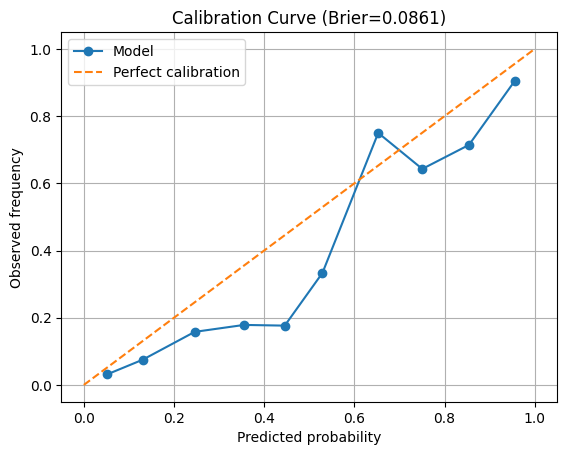

Brier score: 0.0861

===== CLINICAL OPERATING POINT =====
Target specificity: 85%
Operating threshold: 0.376
Sensitivity @ 85% spec: 0.854
Precision @ clinical point: 0.6410256410256411


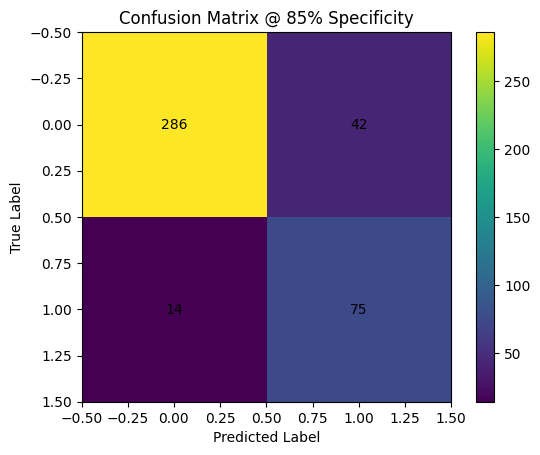

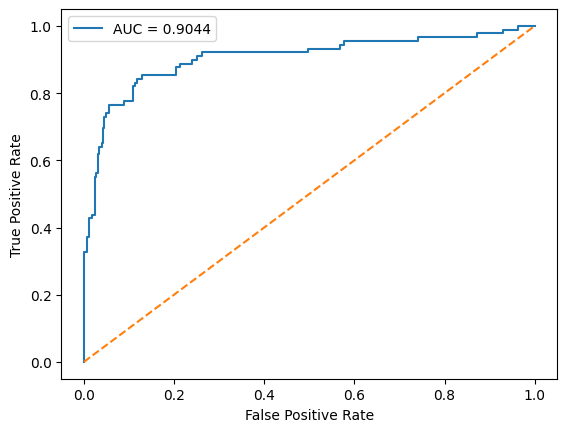

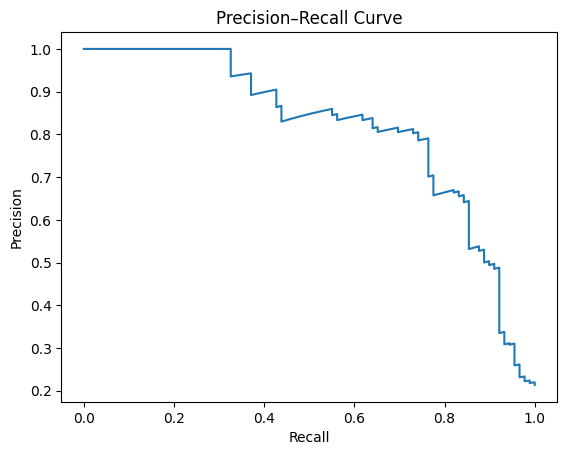

In [18]:
evaluate_murmur_model(model, val_dl)

In [10]:
checkpoint_path = "/kaggle/input/cas-hs-model/pytorch/version-1/2/hs_murmur_model_v3.2.pt"

model = MurmurModel().to(device)

model.load_state_dict(
    torch.load(checkpoint_path, map_location=device)
)

model.to(device)
model.eval()

print("Model loaded successfully from:", checkpoint_path)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Model loaded successfully from: /kaggle/input/cas-hs-model/pytorch/version-1/2/hs_murmur_model_v3.2.pt
